In [1]:
import torch
from torch_geometric.data import download_url, extract_zip

In [9]:
import os
import shutil
import mat73
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import preprocessing

## Real (experimental) data.

We have obtained "whole brain" calcium imaging data from several open source datasets. 


|Paper Link             |Database Link     |Files w/ Data          |Num. ID'd| 
|-----------------------|------------------|-----------------------|---------|
|tinyurl.com/Uzel2022   |osf.io/3vkxn/     |`Uzel_WT.mat`          |54/154   |
|tinyurl.com/Randi2022  |osf.io/e2syt/     |`exported_data_*.tar`  |?        |
|tinyurl.com/Kaplan20   |osf.io/9nfhz/     |`Neuron2019_Data_*.mat`|48/103   |
|~tinyurl.com/Kaplan20~ |~osf.io/eyj92/~  |~`Freely moving *.mat`~ |~8/8~    |
|tinyurl.com/Nguyen17   |tinyurl.com/LeiferIEEE|`heatData*.mat`    |0/156    | 
|tinyurl.com/Skora2018  |osf.io/za3gt/     |`WT_*.mat`             |40/139   |
|tinyurl.com/Nichols2017|osf.io/kbf38/     |`*let.mat`             |35/116   |
|tinyurl.com/Kato2015   |osf.io/cqmnv/     |`Freely moving *.mat`  |8/8      |
|tinyurl.com/Kato2015   |osf.io/2395t/     |`WT_*Stim.mat`         |38/109   |


In [3]:
#@title Download the open source activity datasets.
#@markdown This is a lot of data and takes up to 2 minutes to download

url = 'https://www.dropbox.com/s/9dnzrlh12hf5p89/opensource_data.zip?dl=1'
filename = os.path.join('opensource_data.zip')
download_url(url=url, folder=os.getcwd(), filename=filename)
extract_zip(filename, folder=os.path.join(os.getcwd(), 'neural_datasets/')) # extract zip file
os.unlink(filename) # remove zip file

Extracting opensource_data.zip


### Let's load some real C. elegans data now!

Nguyen et al., PLOS CompBio 2017, *Automatically tracking neurons in a moving and deforming brain* 

This dataset is an example of one with no neuron IDs. The data for each of 3 worms are in the files `heatData_worm*.mat`. These files contain all signal results. The calcium GCaMP signal is in the field `G2`. 

Excerpt from this dataset's `README`:
```
heatData.mat 
Signal variables
	rRaw - an N neurons x T volumes matrix with the raw red signal from each of the neurons. Signals are averaged pixel values around each tracked neuron with no other processing except for flash removal. 
	gRaw - same as rRaw but for the green signal. 

	rPhotoCorr - the rRaw signal after photobleaching correction for each neuron. No other smoothing or normalization is applied. Photobleaching correction is applied by fitting an exponential curve to a wide 20th percentile filter, and then subtraction the exponential from the raw signal.
	gPhotoCorr - same as above but with the green signal. Exponential curves are fit independently. 

	R2 - Smoothed and normalized version of rPhotoCorr.Normalization is done as delta F/ F0, where F0 is the lower 20th percentile signal. 
	G2 - Same as above but with gPhotoCorr.

	Ratio2 - The ratio signal is defined as gPhotoCorr/rPhotoCorr, the Ratio is then normalized as delta R/ R0. is the same way as R2 and G2.


Other fields:
behavior - structure with 
    ethogram: t Volumes by 1 vector of behaviors, -1 for reverse, 0 pause, 1 forward, 2 turn. Behaviors determined automatically using the centerlines.
       x_pos: t Volumes by 1 vector of x coordinates in the reference frame of the plate.
       y_pos: t Volumes by 1 vector of y coordinates in the reference frame of the plate.
           v: t Volumes by 1 vector of worm center of mass velocities in the reference frame of the plate. Positive is forward, negative reverse.
       pc1_2: t Volumes by 2 vector of the projections onto the first two eigenworms. 
        pc_3: t Volumes by 1 vector of the projections onto the third eigenworm. 

XYZcoord - N neurons x 3 XYZ coordinates for the neurons. The coordinates are taken by a random straightened volume from the recording to serve as an example.

acorr - a n Neurons x n Neurons pearson correlation matrix of Ratio2

cgIdx - ordered indices derived from heirarchically clustering the correlation matrix. To show organized traces, use Ratio2(cgIdx,:)

hasPointsTime- a t volumes by 1 vector of time for each volume. 
```

['hasPointsTime', 'ethoTrack', 'R2', 'G2', 'Ratio2', 'acorr', 'cgIdx', 'cgIdxRev', 'rRaw', 'gRaw', 'rPhotoCorr', 'gPhotoCorr']

len. Ca recording 2849, num. neurons 156


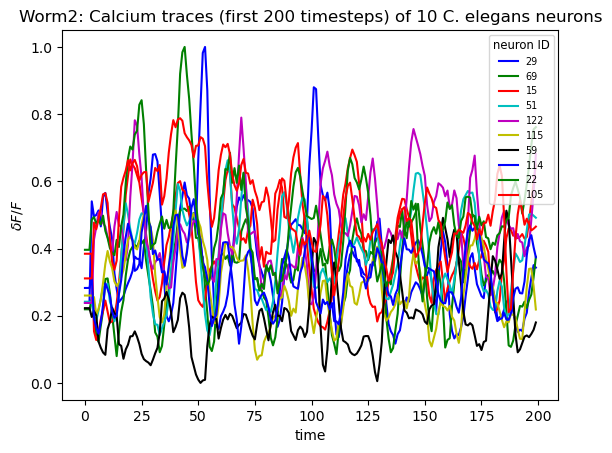

In [6]:
#@title Source: https://ieee-dataport.org/open-access/tracking-neurons-moving-and-deforming-brain-dataset
#@markdown 

# load .mat file for one worm
arr = loadmat('neural_datasets/Nguyen2017/heatData_worm2.mat') # load .mat file
print(list(arr.keys())[3:])
print()

# get data for this worm worms
G2 = arr['G2'] # the ratio signal is defined as gPhotoCorr/rPhotoCorr, the Ratio is then normalized as delta R/ R0. is the same way as R2 and G2.
cgIdx = arr['cgIdx'].squeeze() # ordered indices derived from heirarchically clustering the correlation matrix. 
real_data = G2[cgIdx-1, :].T # to show organized traces, use Ratio2(cgIdx,:)
real_data = np.nan_to_num(real_data) # replace NaNs 
worm_IDs = None
max_time, num_neurons = real_data.shape 
print('len. Ca recording %s, num. neurons %s'%(max_time, num_neurons))

# normalize the data 
sc = preprocessing.MinMaxScaler()
real_data = sc.fit_transform(real_data[:, :num_neurons]) 

# plot data
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')
plt.figure()
inds = np.random.choice(range(num_neurons), 10)
plt.plot(real_data[:200, inds])
plt.legend(inds, title='neuron ID', loc='upper right', 
           fontsize='x-small', title_fontsize='small')
plt.xlabel('time')
plt.ylabel('$\delta F / F$')
plt.title('Worm2: Calcium traces (first 200 timesteps) of 10 C. elegans neurons')
plt.show()

Kaplan et al., Neuron 2020, *Nested Neuronal Dynamics Orchestrate a Behavioral Hierarchy across Timescales*

This dataset consist of whole-brain and whole-nervous system recordings. What's the distinction between "whole-brain" and "whole-nervous system"? 

The nervous system of the C. elegans hermaphrodite is composed of 302 neurons that are organized in several ganglia in the head and tail and into a spinal cord-like ventral nerve cord [1]. The majority of the neurons is located in the head, where they are organised in a number of ganglia surrounding the pharynx, forming the brain of the animal [2].

We will use the the richer whole-nervous system data, which is stored the file `Neuron2019_Data_RIShisCl.mat`. This file contains data from 10 worms.

References: 
- [1] http://www.wormbook.org/chapters/www_specnervsys.2/neurogenesis.html

- [2] https://www.sfu.ca/biology/faculty/hutter/hutterlab/research/Ce_nervous_system.html

Excerpt from this dataset's README:
```
Datasets SMDhisCl_RIShisCl and MNhisCl_RIShisCl consist exclusively of whole-brain (head + tail ganglia)  imaging recordings. 

Dataset RIShisCl consists of both whole-nervous-system recordings (rows 1-5) and whole-brain (head + tail ganglia) recordings (rows6-10).


raw_traces= neural activity traces (uncorrected)

traces_bleach_corrected= neural activity traces corrected for bleaching

traces_derivatives= derivative of neural activity traces (uncorrected)
traces_bleach_corrected_detrended= traces_bleach_corrected that have been further corrected for bleaching by fitting a single exponential function to peaks of the neural traces

volumes_per_second= volumes per second

time_vector= time vector in seconds

neuron_ID= identified neuron IDs, unidentified neurons will have a number assigned as their ID

five_state_annotation= vector of different state types. 5 states for RIShisCl and MNhisCl: 1= ‘FWD’ forward crawling  2= ‘REV’ reverse crawling 3= ‘REVSUS’ sustained reverse crawling 5= ‘DT’ dorsal post reversal turn 6= ‘VT’ ventral post reversal turn 4= ‘UT’ unassigned post reversal turn
4 states for SMDhisCl: 1= ‘FWD’ forward crawling  2= ‘REV’ reverse crawling 3= ‘REVSUS’ sustained reverse crawling 4= ‘UT’ unassigned post reversal turn

peaks= peaks detected on derivative timeseries, for details on peak detection refer to Methods. Briefly, we detected local maxima and minima in each trace: maximum peaks were found as maximal values that were preceded and followed by minima values separated from the maximum by an amplitude difference of at least delta, a key parameter.
```


ERROR:root:ERROR: MATLAB type not supported: function_handle_workspace, (uint32)
ERROR:root:ERROR: MATLAB type not supported: function_handle_workspace, (uint32)
ERROR:root:ERROR: MATLAB type not supported: function_handle_workspace, (uint32)
ERROR:root:ERROR: MATLAB type not supported: function_handle_workspace, (uint32)
ERROR:root:ERROR: MATLAB type not supported: function_handle_workspace, (uint32)
ERROR:root:ERROR: MATLAB type not supported: function_handle_workspace, (uint32)
ERROR:root:ERROR: MATLAB type not supported: function_handle_workspace, (uint32)
ERROR:root:ERROR: MATLAB type not supported: function_handle_workspace, (uint32)
ERROR:root:ERROR: MATLAB type not supported: function_handle_workspace, (uint32)
ERROR:root:ERROR: MATLAB type not supported: function_handle_workspace, (uint32)


['five_state_annotation', 'neuron_ID', 'parameters', 'peaks', 'raw_traces', 'time_vector', 'traces_bleach_corrected', 'traces_bleach_corrected_detrended', 'traces_derivatives', 'volumes_per_second']

num. worms: 10

len. Ca recording 5455, total num. neurons 103, num. ID'd neurons 45


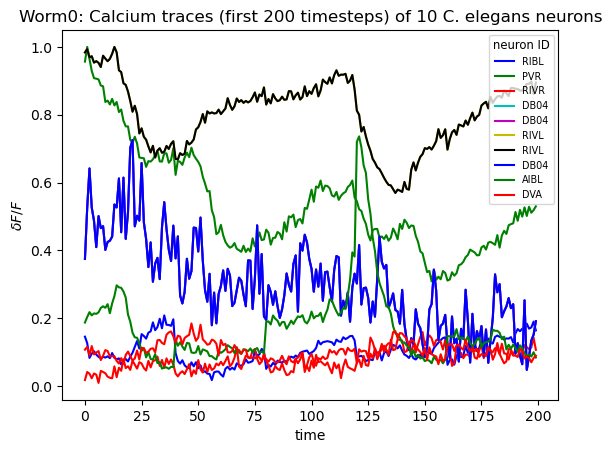

In [7]:
#@title Source: https://osf.io/9nfhz/
#@markdown This dataset has a very similar organization to Uvel et al., 2022.

# load .mat file
arr = mat73.loadmat('neural_datasets/Kaplan2020/Neuron2019_Data_RIShisCl.mat')['RIShisCl_Neuron2019']
print(list(arr.keys()))
print()

# get data for all worms
all_IDs = arr['neuron_ID'] # identified neuron IDs (only subset have neuron names)
all_traces = arr['traces_bleach_corrected'] # neural activity traces corrected for bleaching
print('num. worms:', len(all_IDs))
print()

# get the neuron IDs and calcium of one worm
real_data = all_traces[0]
worm_IDs = [a for a in all_IDs[0] if not a.isnumeric()] 

# filter for named neurons
worm_IDs = {id: j for id,j in enumerate(worm_IDs) if isinstance(j,str)} 
max_time, num_neurons = real_data.shape  
print("len. Ca recording %s, total num. neurons %s, num. ID'd neurons %s"%(
    max_time, num_neurons, len(worm_IDs)))

# normalize the data 
sc = preprocessing.MinMaxScaler()
real_data = sc.fit_transform(real_data[:, :num_neurons]) 

# plot data
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')
plt.figure()
inds = np.random.choice(list(worm_IDs.keys()), size=10)
plt.plot(real_data[:200, inds])
plt.legend([worm_IDs[i] for i in inds], title='neuron ID', loc='upper right', 
           fontsize='x-small', title_fontsize='small')
plt.xlabel('time')
plt.ylabel('$\delta F / F$')
plt.title('Worm0: Calcium traces (first 200 timesteps) of 10 C. elegans neurons')
plt.show()

Uzel et al 2022., Cell CurrBio 2022, *A set of hub neurons and non-local connectivity features support global brain dynamics in C. elegans*

This dataset is from a much more recent paper. the file `Uzel_WT.mat` contains the data for 6 wild-type (WT) worms. In each worm, ~154 neurons are imaged and the 54 these neurons are ID'd (i.e., we have he names of these 54 neurons). The calcium GCaMP signal for each worm is in the field `traces` and the neuron IDs are in the field `IDs`. 

Excerpt from this dataset's `README`:
```
Data format:

	•	traces = neural activity traces corrected for bleaching

	•	derivatives = time-derivatives of traces

	•	options = alpha and iteration number parameters used for the derivative calculation

	•	IDs = identified neuron IDs

	•	tv = time vector in seconds

	•	fps = frames per second

	•	states = vector of different brain state types (Available for WT datasets only)

	•	statesKey = Key for brain states: 1 = forward crawling; 2 = reverse crawling; 3 = sustained reverse crawling; 5 = dorsal post reversal turn; 6 = ventral post reversal turn; 
```

['IDs', 'derivatives', 'fps', 'options', 'states', 'statesKey', 'traces', 'tv']

num. worms: 6

len. Ca recording 3312, total num. neurons 154, num. ID'd neurons 58


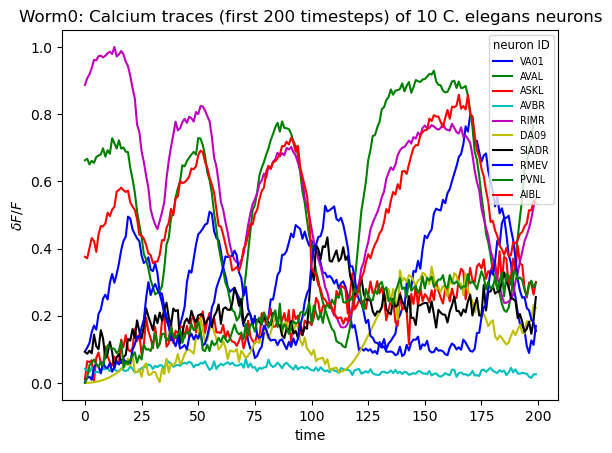

In [8]:
#@title Source: https://osf.io/3vkxn/
#@markdown

# load .mat file
arr = mat73.loadmat('neural_datasets/Uzel2022/Uzel_WT.mat')['Uzel_WT'] # load .mat file
print(list(arr.keys()))
print()

# get data for all worms
all_IDs = arr['IDs'] # identified neuron IDs (only subset have neuron names)
all_traces = arr['traces'] # neural activity traces corrected for bleaching
print('num. worms:', len(all_IDs))
print()

# get the neuron IDs and calcium of one worm
real_data = all_traces[0]
worm_IDs = [np.array(a).item() for a in all_IDs[0]] 

# filter for named neurons
worm_IDs = {id: j for id, j in enumerate(worm_IDs) if isinstance(j,str)} 
max_time, num_neurons = real_data.shape  
print("len. Ca recording %s, total num. neurons %s, num. ID'd neurons %s"%(
    max_time, num_neurons, len(worm_IDs)))

# normalize the data 
sc = preprocessing.MinMaxScaler()
real_data = sc.fit_transform(real_data[:, :num_neurons]) 

# plot data
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')
plt.figure()
inds = np.random.choice(list(worm_IDs.keys()), size=10)
plt.plot(real_data[:200, inds])
plt.legend([worm_IDs[i] for i in inds], title='neuron ID', loc='upper right', 
           fontsize='x-small', title_fontsize='small')
plt.xlabel('time')
plt.ylabel('$\delta F / F$')
plt.title('Worm0: Calcium traces (first 200 timesteps) of 10 C. elegans neurons')
plt.show()

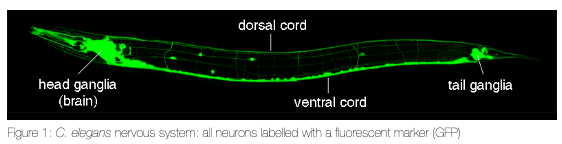

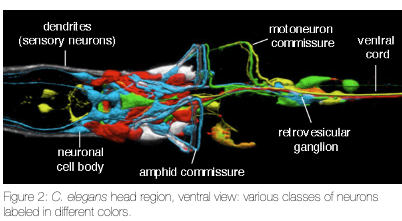

In [10]:
#@title Delete the unzipped datasets.
#@markdown The files are too large to push to GitHub.
shutil.rmtree('neural_datasets/')